In [1]:
from functools import partial
from sqlite3 import connect

import astroplan as ap
from astropy.coordinates import EarthLocation
from astropy.table import Table
from astropy.time import Time
import astropy.units as u
from icecream import ic, install
import numpy as np
import pandas as pd

import astropaul.targetlistcreator as tlc
import astropaul.lbt as lbt
import astropaul.html as html
import astropaul.phase as ph
import astropaul.priority as pr

install() # icecream will now work in imported packages

%load_ext autoreload
%autoreload 2


In [2]:
conn = connect("../../django/TargetDB/db.sqlite3")
html_dir = "html"

session = tlc.ObservingSession(ap.Observer.at_site("LBT"))
session.add_day_range("2025-02-25", "2025-03-01")

phase_defs = [
    ph.PhaseEventDef("T", partial(ph.calc_time_of_phase, phase=0.0)),
    ph.PhaseEventDef("B", partial(ph.calc_time_of_phase, phase=0.05)),
    ph.PhaseEventDef("R", partial(ph.calc_time_of_phase, phase=0.18)),
    ph.PhaseEventDef("B", partial(ph.calc_time_of_phase, phase=0.32)),
    ph.PhaseEventDef("T", partial(ph.calc_time_of_phase, phase=0.45)),
    ph.PhaseEventDef("B", partial(ph.calc_time_of_phase, phase=0.55)),
    ph.PhaseEventDef("R", partial(ph.calc_time_of_phase, phase=0.68)),
    ph.PhaseEventDef("B", partial(ph.calc_time_of_phase, phase=0.82)),
    ph.PhaseEventDef("T", partial(ph.calc_time_of_phase, phase=0.95)),
]

pepsi_args = {
    "fiber": "300",
    "cd_blue": 3,
    "cd_red": 6,
    "snr": 100,
    "binocular": True,
    "priority": "(see grid)",
}

name = "LBT Observing List 2024-12-21"
creator = tlc.TargetListCreator(name=name, connection=conn)
creator.steps = [
    tlc.add_targets,
    partial(tlc.filter_targets, criteria=lambda df: (df["Target Type"].isin(["QuadEB", "SextEB"]))),
    tlc.add_tess,
    tlc.add_coords,
    partial(tlc.hide_cols, prefix="TESS "),
    # tlc.add_speckle,
    tlc.add_pepsi,
    tlc.add_lists,
    tlc.add_ephemerides,
    partial(tlc.filter_targets, criteria=lambda df: (df["Num PEPSI"] > 0)),
    partial(tlc.filter_targets, criteria=lambda df: (df["List LBT 2025A"])),
    partial(tlc.concat_dataframe, other_df=pd.read_csv("Calibration Targets.csv")),
    partial(tlc.add_observability, observing_session=session, calc_moon_distance=True),
    partial(tlc.filter_targets, criteria=lambda df: (df["Observable Any Night"])),
    # partial(tlc.filter_targets, criteria=lambda df: (df["Observable Max Alt"] > 40)),
    partial(tlc.filter_targets, inverse=True, criteria=lambda df: np.isnan(df["Teff"])),
    partial(lbt.add_pepsi_params, **pepsi_args),
    partial(tlc.filter_targets, criteria=lambda df: df["PEPSI exp_time"] < 400),
    partial(lbt.assign_rv_standards, science_types=["QuadEB", "SextEB"], rv_standard_type="RV Standard"),
    partial(tlc.add_rv_status, phase_event_defs=phase_defs),
]
tl = creator.calculate(verbose=False)
tl.target_list["PEPSI notes"] = [type.replace("QuadEB", "Science Target") for type in tl.target_list["Target Type"]]
readme = lbt.write_lbt_readme_file("UVa_Multistar", tl.target_list, session)

print(tl.summarize())
print(f"{np.sum(tl.target_list["PEPSI exp_time"])/60:.1f} minutes")
# tl.target_list

LBT Observing List 2024-12-21
28 targets:
      17 QuadEB
       8 RV Standard
       3 Telluric Standard
Column Count (primary, secondary):
    Target: (1, 2)
    Coordinates: (6, 3)
    Count: (1, 0)
    List : (0, 11)
    Observable: (5, 20)
    PEPSI : (3, 6)
Associated tables:
     103 rows,  8 columns: PEPSI
     673 rows,  7 columns: Ephem
       5 rows,  2 columns: Lunar Phases
     103 rows,  5 columns: PEPSI RV Status

63.8 minutes


In [3]:
illumination_categories = [
    ((0.0, 0.4), "Dark"),
    ((0.4, 0.7), "Gray"),
    ((0.7, 1.0), "Bright"),
]

distance_categories = {
    "Dark": [
        ((0, 180), 1),
    ],
    "Gray": [
        ((0, 5), 0.1),
        ((5, 15), 0.75),
        ((15, 180), 1),
    ],
    "Bright": [
        ((0, 15), 0.25),
        ((15, 30), 0.75),
        ((30, 180), 1),
    ],
}

altitude_categories = [
    ((-90, 35), 0),
    ((35, 45), 0.95),
    ((45, 90), 1),
]

phase_scores = {
    "B|B": 0.5,
    "B|R": 0.8,
    "B|T": 0.4,
    "R|B": 0.8,
    "R|R": 0.9,
    "R|T": 1,
    "T|B": 0.4,
    "T|R": 1,
    "T|T": 0.1,
}

science_tl = tl.copy()
science_tl.target_list = science_tl.target_list[science_tl.target_list["Target Type"] == "QuadEB"]
pl = pr.PriorityList(science_tl, session, interval=60 * u.min)
pr.calculate_moon_priority(pl, illumination_categories=illumination_categories, dist_categories=distance_categories)
pr.calculate_altitude_priority(pl, altitude_categories=altitude_categories)
pr.calculate_list_priority(pl, "HQND", false_value=0.75)
pr.calculate_phase_priority(pl, phase_defs=phase_defs, phase_categories=phase_scores)
pr.calculate_overall_priority(pl)
pr.aggregate_target_priorities(pl, skip_column_threshold=0.1)
pl.categorize_priorities(
    bins=[0.00, 0.20, 0.40, 0.6, 1.00], labels=["", "*", "* *", "* * *"]
)

 '2025-02-25T04:00:00.000000000' '2025-02-25T05:00:00.000000000'
 '2025-02-25T06:00:00.000000000' '2025-02-25T07:00:00.000000000'
 '2025-02-25T08:00:00.000000000' '2025-02-25T09:00:00.000000000'
 '2025-02-25T10:00:00.000000000' '2025-02-25T11:00:00.000000000'
 '2025-02-25T12:00:00.000000000'], obsgeoloc=[( 1.39965542e+06,  5191811.21324667, 3424116.17710799),
 ( 4.69555589e+03,  5374995.57289193, 3427522.59183459),
 (-1.39001131e+06,  5189895.09121764, 3430942.74007115),
 (-2.68890003e+06,  4649192.83112942, 3434142.28083679),
 (-3.80297094e+06,  3789937.64112755, 3436901.98586427),
 (-4.65588804e+06,  2671005.57323131, 3439032.76086039),
 (-5.18920957e+06,  1369065.70388359, 3440388.60221638),
 (-5.36639239e+06,   -26673.22076082, 3440876.60137593),
 (-5.17529598e+06, -1420575.35601128, 3440463.31134807),
 (-4.62901421e+06, -2717130.71373457, 3439177.03910379),
 (-3.76497825e+06, -3827499.49377216, 3437105.90674159)] m, obsgeovel=[(-378.58202029,  1.01453166e+02,  0.92248464),
 (-391.

In [4]:

readme = lbt.write_lbt_readme_file("UVa_Multistar", tl.target_list, session)
with open("UVa_Multistar.README", "w") as f:
    f.write(readme)

other_files = {
    "LBT Readme": lbt.write_lbt_readme_file("UVa_Multistar", tl.target_list, session),
    "LBT CSV": open("UVa_Multistar.csv", "r").readlines(),
}

html.render_observing_pages(tl, pl, other_files, "html")
# pl.categorical_priorities[0]

In [5]:
# for categorical_file in glob.glob("*.*"):
for categorical_file in glob.glob("html/Categorical Priorities *.html"):
    html.html_to_pdf(categorical_file, categorical_file.replace(".html", ".pdf"))
    print(categorical_file)

NameError: name 'glob' is not defined

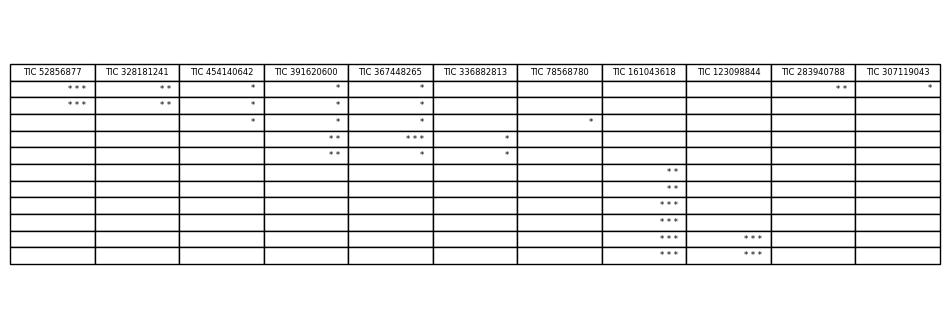

In [29]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

df = pl.categorical_priorities[0].copy()

fig, ax = plt.subplots(figsize=(12, 4))
ax.axis("tight")
ax.axis("off")
the_table = ax.table(cellText=df.values, colLabels=df.columns, loc="center")

pp = PdfPages("foo.pdf")
pp.savefig(fig, bbox_inches="tight")
pp.close()

In [30]:
from playwright.sync_api import sync_playwright


def html_to_pdf(input_html_path, output_pdf_path):
    with sync_playwright() as p:
        # Launch a browser
        browser = p.chromium.launch()
        page = browser.new_page()

        # Load the local HTML file
        page.goto(input_html_path)

        # Generate the PDF
        page.pdf(path=output_pdf_path, format="A4")
        print(f"PDF saved to {output_pdf_path}")

        # Close the browser
        browser.close()


# Call the function
html_to_pdf("test.html", "asd.pdf")

Error: It looks like you are using Playwright Sync API inside the asyncio loop.
Please use the Async API instead.

In [9]:
with open("html/Categorical Priorities 2024-12-21.html", "r") as f:
    content = f.read()

from playwright.sync_api import sync_playwright

with sync_playwright() as p:
    browser = p.chromium.launch()
    page = browser.new_page()
    # page.set_content(content)
    page.goto("file://test.html")
    page.pdf("foo.pdf")
    browser.close()

Error: It looks like you are using Playwright Sync API inside the asyncio loop.
Please use the Async API instead.